# Intro

TODO

## Describe the model

TODO

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import datetime

from scipy import optimize
import theano as thno
import theano.tensor as T

# data retrieval helper module
from general.DB import DB
import util

# plotting libraries
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
%matplotlib inline

When starting a new problem using PyMC and other probabilistic models, it's _always_ a good idea validate the model by using synthetic data first. In other words, generate some data by the process which your model describes, and see how well you can recover the true model parameters. In this case, we define a function that generates random ratings for a number of teams, and then simulates a number of games between these teams using the probabilistic process we defined previously.

In [362]:
def gen_synthetic_data(num_teams, num_games, std_poss=5, seed=0):
    """
    A helper function for generating synthetic pace data
    """
    np.random.seed(seed)
    team_pace_stddev = 3
    # generate some random pace ratings for teams
    pace_ratings = np.random.normal(0, team_pace_stddev, num_teams)
#     pace_ratings = np.concatenate([np.array([0]), pace_ratings])
#     pace_ratings = pace_ratings - np.mean(pace_ratings)
    avg_poss = 65.0
    # randomly pair teams in matchups
    games = np.array([np.random.choice(np.arange(num_teams), 2, replace=False) \
                      for x in range(num_games)])
    
#     mus = (pace_ratings[games[:, 0].ravel()] + pace_ratings[games[:, 1].ravel()]) / 2.0
    mus = avg_poss + pace_ratings[games[:, 0]] + pace_ratings[games[:, 1]]
    possessions = np.random.normal(mus, std_poss)
    
    return possessions, games, pace_ratings

We define a helper function provide an intelligent initial guess for each team's rating.

In [363]:
np.concatenate([np.array([0]), np.array([1,2,3])])

array([0, 1, 2, 3])

In [364]:
def get_initial_values(data, games, num_teams):
    """
    Center the priors around team_avg - total_avg
    """
    sums = np.zeros(num_teams)
    counts = np.zeros(num_teams)
    for i, (ih, ia) in enumerate(games):
        sums[ih] += data[i]
        sums[ia] += data[i]
        counts[ih] += 1
        counts[ia] += 1
    avgs = sums / counts
    avgs[np.isnan(avgs)] = np.nanmean(avgs)
    return avgs - np.mean(avgs)

In [365]:
# Generate synthetic data
num_teams_synth = 60
num_games_synth = 1000
observed_possessions_synth, game_indices_synth, true_team_ratings = gen_synthetic_data(num_teams_synth, num_games_synth, seed=15)
mean_possessions_synth = np.mean(observed_possessions_synth)
print("Generated possessions for %d games: average possessions = %0.2f" % \
      (observed_possessions_synth.shape[0], mean_possessions_synth))
# store team ratings in a dataframe
teams_df_synth = pd.DataFrame({'team_idx': np.arange(num_teams_synth), 'rating': true_team_ratings})
# print(true_team_ratings)
# print(observed_possessions_synth)
# print(game_indices_synth)

Generated possessions for 1000 games: average possessions = 64.59


In [366]:
idx = (game_indices_synth + num_teams_synth * np.arange(num_games_synth)[:, np.newaxis]).ravel()
X = np.zeros(num_games_synth * num_teams_synth)
X[idx] = 1
X = X.reshape(num_games_synth, num_teams_synth)
y = observed_possessions_synth
df = pd.DataFrame(X, columns=["x" + str(i) for i in range(num_teams_synth)])
df['y'] = y
df.head()
feature_cols = ["x%s" % str(i) for i in range(1, num_teams_synth)]
# subdf = df[feature_cols + ["y"]]
X = df[feature_cols].values
y = df.y.values

In [367]:
lr = LinearRegression()
lr.fit(X, y)
lr.coef_.shape

(59,)

In [368]:
with pm.Model() as lr_model:
    coefs = pm.Normal("coefs", mu=lr.coef_, sd=5, shape=lr.coef_.shape[0])
    intercept = pm.Normal("intercept", mu=lr.intercept_, sd=5)
    std = pm.HalfNormal('std', 5)
    
    mus = T.dot(X, coefs) + intercept
    target = pm.Normal("target", mu=mus, sd=std, observed=y.ravel())

Applied log-transform to std and added transformed std_log to model.


In [369]:
with lr_model:
    step = pm.NUTS([coefs, intercept, mus, target, std])
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell)
    traces = pm.sample(1000, start=start_MAP, step=step, progressbar=True)

 [-----------------100%-----------------] 1000 of 1000 complete in 2.2 sec

In [372]:
np.mean(lr.coef_) + lr.intercept_
true_team_ratings

array([ -9.36985445e-01,   1.01785412e+00,  -4.67725602e-01,
        -1.50536902e+00,   7.06706675e-01,  -5.29081577e+00,
        -3.28758613e+00,  -3.26329722e+00,  -9.15510156e-01,
        -1.42124512e+00,  -6.01783616e-01,   1.06559032e+00,
         2.06855317e+00,   1.23176903e+00,  -1.69493531e+00,
         1.79817207e+00,  -4.88808916e-01,   4.80064351e+00,
         2.04488161e+00,   4.46403040e-02,  -2.63338897e-01,
        -2.94635352e+00,   3.65071436e-01,  -3.41231186e+00,
         1.04700773e+00,  -5.57553948e+00,  -3.50154566e+00,
         4.27469049e+00,   4.48969609e+00,   3.86979617e+00,
        -5.43523580e+00,  -4.49492163e+00,  -4.35042965e+00,
        -5.08172088e+00,   6.81792083e-01,  -1.46920413e+00,
        -1.58551954e-03,  -1.47075785e+00,  -2.37962827e+00,
         6.14669629e+00,   1.80955632e+00,  -2.99460623e+00,
         3.64512465e+00,  -2.00254947e+00,  -8.17517331e-01,
         4.25032344e+00,  -2.34782687e+00,  -7.50962091e-01,
        -9.24943384e-01,

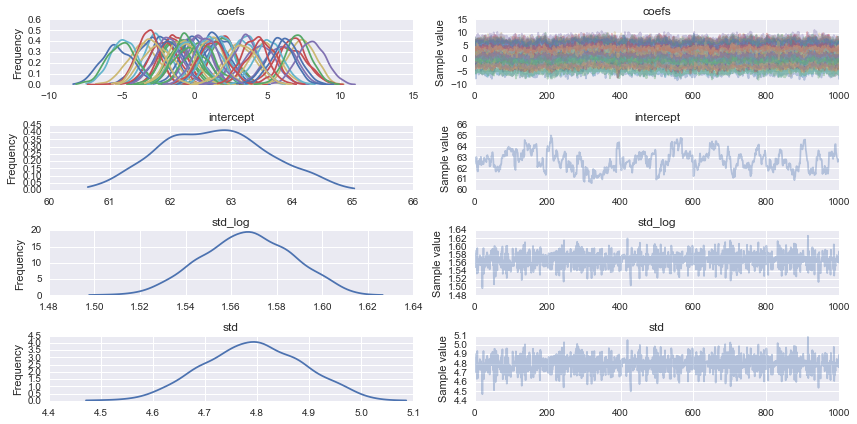

In [371]:
_ = pm.traceplot(traces, figsize=(12, len(traces.varnames) * 1.5))

Now we can define our model using PyMC3.

In [310]:
# define some variables to use when declaring the model
initial_guess_synth = get_initial_values(observed_possessions_synth, game_indices_synth, num_teams_synth)
home_team_idx_synth = game_indices_synth[:, 0]
away_team_idx_synth = game_indices_synth[:, 1]

In [311]:
with pm.Model() as pace_model_synthetic:
    base_possessions_synth = pm.Normal("base_possessions_synth", mu=mean_possessions_synth, sd=10)
    team_ratings_synth = pm.Normal("team_ratings_synth", mu=initial_guess_synth, 
                                   sd=10, shape=num_teams_synth)
#     T.set_subtensor(team_ratings_synth[0], team_ratings_synth[1:].sum())
#     base_shifted = pm.Deterministic('base_shifted', base_possessions_synth + team_ratings_synth.mean())
#     team_shifted = pm.Deterministic('team_shifted', team_ratings_synth.copy() - team_ratings_synth.mean())
#     to include centered ratings in the model summary, wrap it in `pm.Deterministic`
    centered_ratings_synth = pm.Deterministic('centered_ratings_synth', 
                                              team_ratings_synth - T.mean(team_ratings_synth))
    
    # number of possessions in a game is drawn from normal distribution, centered at `mu_poss_synth`
    mu_poss_synth = base_possessions_synth + \
        centered_ratings_synth[home_team_idx_synth] + centered_ratings_synth[away_team_idx_synth]

    std_poss_synth = pm.Gamma('std_poss_synth', alpha=2, beta=2)
    num_poss_synth = pm.Normal('num_poss_synth', mu=mu_poss_synth, sd=std_poss_synth, 
                               observed=observed_possessions_synth)

INFO (theano.gof.compilelock): Refreshing lock /Users/sethhendrickson/.theano/compiledir_Darwin-14.3.0-x86_64-i386-64bit-i386-3.4.3-64/lock_dir/lock


Applied log-transform to std_poss_synth and added transformed std_poss_synth_log to model.


In the model definition above, we put a normal prior around the mean possession parameter, and center the prior density at the mean of all possessions recorded for the season. We also define normal priors for each team, centered around each team's season average possessions. We do this using a single PyMC parameter, by passing a `shape=num_teams` argument. 

For each game, the number of possessions is generated from a normal distribution with a mean that is a function of the base possessions and each team's pace rating. We model the standard deviation of the number of possessions in a game as an unknown quantity that is constant for all games (i.e. it is not affected by the teams that are playing). The number of possessions in each game is actually a known quantity, and we wish to tell PyMC to find the other model parameters that would make the actual data most likely, given the model we defined. To do this, we simply pass in the observed data via a keyword argument to the `pm.Normal` parameter. PyMC will take care of the inference for us from there.

Below, we define the sampler that we want to use, provide the MCMC algorithm with the MAP estimate as a starting point, and take samples from the posterior.

In [312]:
with pace_model_synthetic:
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell)
    step = pm.NUTS(state=start_MAP)
#     step2 = pm.Metropolis([base_possessions_synth])
    # begin sampling at the maximum a posteriori values for the model parameters
    
    print(start_MAP['base_possessions_synth'])
    
    # take samples
    traces_synth = pm.sample(1000, start=start_MAP, step=step, progressbar=True)

64.69832578169293
 [-----------------100%-----------------] 1000 of 1000 complete in 1.8 sec

The `traces` variable contains the 5000 posterior samples for each of the model parameters. We can use PyMC's built in trace plot feature to visualize the results. On the left, we will see histograms for each parameter made from the samples in the trace, while on the right we see the raw samples plotted as a function sampling iteration. 

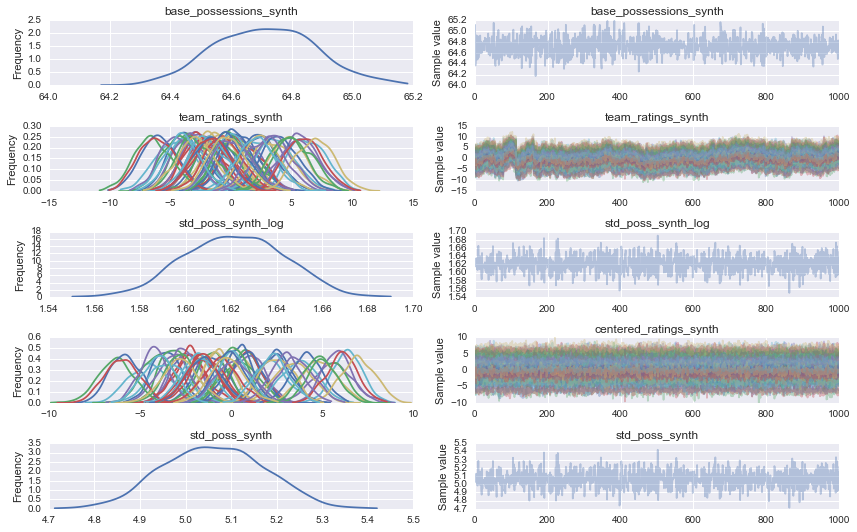

In [313]:
burn_samples = 0
_ = pm.traceplot(traces_synth, figsize=(12, len(traces_synth.varnames) * 1.5))

TODO: explain what we'd like to see here, and list some references.

We started this exercise by generating fake data, with the eventual aim to validate that our model could, in fact, recover the true model parameters. In real world scenarios, we don't know the true parameters so it is difficult to assess how good the model really is. However, when we generate fake data, we do know the true parameters and so we can validate against something concrete. We know that we won't perfectly recover the exact values for the parameters because we are modeling a random process, but we hope that we can get pretty close. As Bayesians, we have the advantage of getting a _distribution_ for our parameter estimates instead of just a single point estimate. This means that, for each team, we get a probability distribution for what their _true_ rating actually is. PyMC summarizes these distributions for us in the form of 95% HPD (Highest Posterior Density) intervals. Essentially, this will give us a range (interval) of the parameter space that contains the true parameter value with 95% probability. Perhaps an example will be clearer.

For the base possessions parameter, we _know_ that the true value is 65.0, because we chose it to be just that. Let's check the 95% HPD interval for this parameter, obtained via MCMC sampling, and see if it contains 65.

In [314]:
# base_poss_row = pm.df_summary(traces_synth[burn_samples:]).loc['base_possessions_synth']
# # TODO: check HPD for more details
# print("95%% of the posterior samples for 'base_possessions_synth' are in the interval [%0.3f, %0.3f]" % \
#     (base_poss_row['hpd_2.5'], base_poss_row['hpd_97.5']))

Wow, that is close! The sample mean, which we looked at earlier, was 

We can perform similar checks for each of the team rating parameters. Below, we check that each 95% HPD interval contains the true rating for each team.

In [315]:
pace_indices = ['centered_ratings_synth__%s' % i for i in np.arange(num_teams_synth)]
team_summary_synth = pm.df_summary(traces_synth[burn_samples:]).loc[pace_indices]

# add the 95% posterior interval upper and lower bounds for each team
teams_df_synth['lower_bound'] = team_summary_synth['hpd_2.5'].values
teams_df_synth['upper_bound'] = team_summary_synth['hpd_97.5'].values

def within_bounds(x, lb, ub):
    return (x >= lb) and (x <= ub)
teams_df_synth['captured'] = teams_df_synth.apply(lambda row: \
                                                  within_bounds(row.rating, row.lower_bound, row.upper_bound), axis=1)
print("%0.2f%% of true ratings captured in posterior bounds"% (teams_df_synth['captured'].mean()*100))
# team_summary_synth

93.33% of true ratings captured in posterior bounds


In [246]:
# pm.df_summary(traces_synth[burn_samples:])
teams_df_synth[~teams_df_synth['captured']]

,rating,team_idx,lower_bound,upper_bound,captured
5,-4.886389,5,-13.023348,-5.453847,False
22,4.322181,22,-3.530943,3.989737,False


## Tempo ratings for divison I NCAA basketball

### Compare with kenpom

In [244]:
# get the data we need from the database
games_df, stacked, teams = util.get_data(2016)
games_df = games_df.sort('dt')  # sort by date ascending
last_games = games_df.iloc[-1:]
games_df = games_df.iloc[:-1]
kenpom = pd.read_sql("SELECT team, adjt FROM kenpom_ranks WHERE year = 2016", DB.conn)
all_teams = pd.read_sql("SELECT ncaa, ncaaid, kenpom FROM teams", DB.conn)
teams = teams.merge(all_teams, left_on='team_id', right_on='ncaaid')
teams = teams.merge(kenpom, how='left', left_on='kenpom', right_on='team').drop(['team', 'kenpom'], 1)
num_teams = teams.shape[0]
print("Got data for %s games and %s teams, between %s and %s" % (games_df.shape[0], num_teams,
                                                   datetime.datetime.strftime(games_df['dt'].min(), "%m-%d-%Y"),
                                                  datetime.datetime.strftime(games_df['dt'].max(), "%m-%d-%Y")))

Got data for 5454 games and 351 teams, between 11-13-2015 and 04-02-2016


In [245]:
pretty_columns = ['game_id', 'dt', 'hteam', 'ateam', 'hpts', 'hposs', 'apts', 
                  'aposs', 'poss', 'neutral', 'home_outcome']
games_df[pretty_columns].head()

,game_id,dt,hteam,ateam,hpts,hposs,apts,aposs,poss,neutral,home_outcome
4905,3948876,2015-11-13,Louisville,Samford,86.0,74.775,45.0,75.450,75.1125,False,True
191,3951809,2015-11-13,George Mason,Colgate,53.0,67.625,66.0,65.350,66.4875,False,False
447,3951861,2015-11-13,Hawaii,Montana St.,87.0,72.350,76.0,73.350,72.8500,False,True
2749,3949125,2015-11-13,Mississippi St.,Eastern Wash.,106.0,78.400,88.0,77.450,77.9250,False,True
1162,3951908,2015-11-13,Northern Ill.,Cal St. Northridge,83.0,71.150,71.0,70.725,70.9375,False,True


In [246]:
# define some variables to use when declaring the model
observed_possessions = games_df['poss'].values
game_indices_predict = last_games[['i_hteam', 'i_ateam']].values
game_indices = games_df[['i_hteam', 'i_ateam']].values
observed_mean = np.mean(observed_possessions)
pace_initial = get_initial_values(observed_possessions, game_indices, num_teams)
home_team_idx = game_indices[:, 0]
away_team_idx = game_indices[:, 1]
home_team_p_idx = game_indices_predict[:, 0]
away_team_p_idx = game_indices_predict[:, 1]
print(observed_possessions.shape)
print(observed_mean)

(5454,)
69.739766685


In [247]:
with pm.Model() as pace_model_2016:
    mean_possessions = pm.Normal("mean_possessions", mu=observed_mean, sd=10)
    team_ratings = pm.Normal("team_ratings", mu=pace_initial, sd=np.ones(num_teams) * 15, shape=num_teams)
    team_ratings_const = pm.Deterministic('team_ratings_const', team_ratings.copy() - team_ratings.copy().mean())
    
    # number of possessions in a game is drawn from normal distribution, centered at `mu_pace` which is deterministic 
    # function of home and away ratings
    mu_poss = mean_possessions + team_ratings_const[home_team_idx] + team_ratings_const[away_team_idx]
    mu_predict = mean_possessions + team_ratings_const[home_team_p_idx] + team_ratings_const[away_team_p_idx]

    std_poss = pm.Uniform('std_poss', 0.1, 10)
    num_poss = pm.Normal('num_poss', mu=mu_poss, sd=std_poss, observed=observed_possessions)
    predict = pm.Normal('predict', mu=mu_predict, sd=std_poss, shape=last_games.shape[0])

INFO (theano.gof.compilelock): Refreshing lock /Users/sethhendrickson/.theano/compiledir_Darwin-14.3.0-x86_64-i386-64bit-i386-3.4.3-64/lock_dir/lock


Applied interval-transform to std_poss and added transformed std_poss_interval to model.


In [257]:
with pace_model_2016:
    step = pm.NUTS([team_ratings, mu_poss, std_poss, num_poss, team_ratings_const, mean_possessions, predict])
#     start_MAP = pm.find_MAP(fmin=optimize.fmin_powell)
    
    # take samples
    traces = pm.sample(1000, start=start_MAP, step=step, progressbar=True)

 [-----------------100%-----------------] 1000 of 1000 complete in 7.4 sec

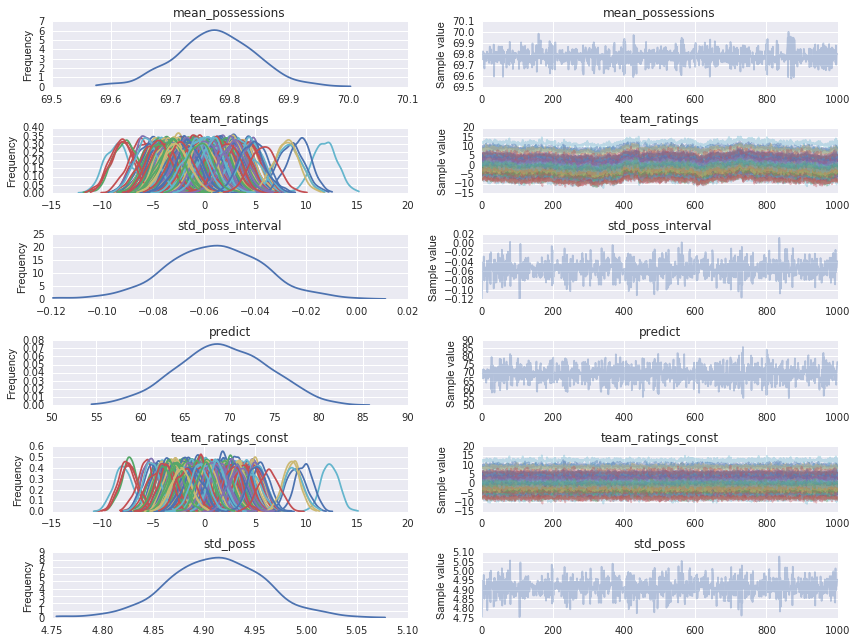

In [258]:
burn_samples = 0
_ = pm.traceplot(traces[:], figsize=(12,len(traces.varnames)*1.5))

The traceplot shows very little autcorrelation in the mean possessions and standard deviation parameters, which gives us confidence that they have successfully converged. The team ratings are a bit harder to diagnose. TODO.

It is difficult to evaluate the accuracy of the results without using the ratings in a prediction setting (and even then, it will be hard to say what is "good"). For now, we can get a good gauge of the accuracy of the results by comparing them with Kenpom's adjusted tempo ratings (assuming we believe _those_ are accurate). For now, testing against a hardened rating system that has been in place for ~10 years will be a good metric. We'll start by aggregating our results into the "teams" dataframe.

In [241]:
pace_indices = ['team_ratings_const__%s' % i for i in np.arange(num_teams)]
summary = pm.df_summary(traces[burn_samples:])
team_summary = summary.loc[pace_indices]
mean_possessions_MAP = summary.loc['mean_possessions']['mean']
std_possessions_MAP = summary.loc['std_poss']['mean']

# add the 95% posterior interval upper and lower bounds for each team
teams['lower_bound'] = team_summary['hpd_2.5'].values + mean_possessions_MAP
teams['upper_bound'] = team_summary['hpd_97.5'].values + mean_possessions_MAP
teams['tempo_MAP'] = team_summary['mean'].values + mean_possessions_MAP
teams['start_MAP'] = start_MAP['team_ratings'] - np.mean(start_MAP['team_ratings']) + mean_possessions_MAP
teams['HPD_width'] = teams['upper_bound'] - teams['lower_bound']

In [242]:
teams

,team_id,i_team,ncaa,ncaaid,adjt,lower_bound,upper_bound,tempo_MAP,HPD_width,start_MAP
0,2.0,0,Abilene Christian,2.0,68.5,67.207540,71.219101,69.137252,4.011560,69.131154
1,5.0,1,Akron,5.0,68.3,66.808992,70.062330,68.432688,3.253338,68.439752
2,6.0,2,Alabama A&M,6.0,66.0,65.012004,68.889556,67.050490,3.877552,67.042565
3,7.0,3,Alabama St.,7.0,69.8,69.430416,72.938836,71.272174,3.508420,71.242688
4,8.0,4,Alabama,8.0,65.2,64.840917,68.141720,66.471520,3.300803,66.471352
5,9.0,5,UAB,9.0,69.3,68.200578,71.869505,70.009130,3.668927,70.009705
6,14.0,6,Albany (NY),14.0,67.5,66.380652,69.780877,68.138772,3.400224,68.128098
7,17.0,7,Alcorn,17.0,66.0,66.100618,69.579861,67.933006,3.479243,67.921517
8,23.0,8,American,23.0,62.4,60.659822,64.136407,62.356332,3.476586,62.356333
9,27.0,9,Appalachian St.,27.0,71.3,69.356684,72.854130,71.130163,3.497446,71.133542


In [148]:
kp_in_bounds = teams.apply(lambda row: within_bounds(row.adjt, row.lower_bound, row.upper_bound), axis=1)
print("%s of %s (%2.2f%%) HPD bounds contained Kenpom rating" % \
      (kp_in_bounds.sum(), teams.shape[0], kp_in_bounds.mean() * 100))

329 of 351 (93.73%) HPD bounds contained Kenpom rating


Only 6 of the teams that were rated had a Kenpom adjusted tempo rating that did not fall in their 95% HPD bounds of the result obtained using PyMC. Let's take a look at them.

In [149]:
teams[~kp_in_bounds]

,team_id,i_team,ncaa,ncaaid,adjt,lower_bound,upper_bound,tempo_MAP,HPD_width
7,17.0,7,Alcorn,17.0,66.0,66.040894,69.659888,67.911020,3.618994
13,31.0,13,Arkansas,31.0,70.5,70.903135,74.462179,72.645791,3.559044
17,47.0,17,Ball St.,47.0,66.1,66.144287,69.593698,67.743061,3.449411
42,108.0,42,UC Davis,108.0,66.6,66.845135,70.590929,68.704339,3.745794
47,116.0,47,Canisius,116.0,67.8,68.590220,71.961761,70.305421,3.371541
52,140.0,52,Cincinnati,140.0,65.5,66.120844,69.462027,67.716773,3.341183
58,156.0,58,Colorado St.,156.0,68.7,69.429600,72.834291,71.116569,3.404691
62,165.0,62,Coppin St.,165.0,70.8,72.072195,75.819693,73.868963,3.747498
103,272.0,103,Hartford,272.0,69.8,70.094098,73.441798,71.792078,3.347700
109,288.0,109,Houston,288.0,66.9,66.940764,70.372935,68.552109,3.432170


## Tempo Prediction

We mentioned above that a true test of our rating would be to use them in a prediction setting. That is, let's try to apply these ratings to predict the number of possessions in real games.

In [201]:
teams[teams['ncaa'].isin(['Villanova', 'North Carolina', 'Syracuse', 'Oklahoma'])]

,team_id,i_team,ncaa,ncaaid,adjt,lower_bound,upper_bound,tempo_MAP,HPD_width
174,457.0,174,North Carolina,457.0,71.1,70.232175,73.493155,71.853039,3.260980
210,522.0,210,Oklahoma,522.0,70.4,70.183014,73.528415,71.857471,3.345402
276,688.0,276,Syracuse,688.0,65.6,64.895915,68.190457,66.436379,3.294542
304,739.0,304,Villanova,739.0,66.5,65.750453,68.877892,67.389336,3.127439


In [151]:
last_games

,game_id,dt,hteam,hteam_id,ateam,ateam_id,hpts,hposs,apts,aposs,i_hteam,i_ateam,hppp,appp,neutral,home_outcome,poss,season
4699,4087620,2016-03-31,George Washington,249.0,Valparaiso,735.0,76.0,65.350,60.0,65.850,94,301,1.162969,0.911162,True,True,65.600,2016
4971,4089097,2016-04-01,Nevada,466.0,Morehead St.,444.0,85.0,78.375,82.0,78.175,181,169,1.084530,1.048929,False,True,78.275,2016
313,4090446,2016-04-02,Oklahoma,522.0,Villanova,739.0,51.0,63.225,95.0,62.025,210,304,0.806643,1.531640,False,False,62.625,2016
904,4090447,2016-04-02,North Carolina,457.0,Syracuse,688.0,83.0,66.225,66.0,66.175,174,276,1.253303,0.997355,True,True,66.200,2016
903,4093479,2016-04-04,North Carolina,457.0,Villanova,739.0,74.0,64.175,77.0,64.075,174,304,1.153097,1.201717,True,False,64.125,2016


In [177]:
t = traces[3000:]['team_ratings_const']
unc_traces = t[:, 174]
nova_traces = t[:, 304]
syracuse_traces = t[:, 276]
unc_mean = np.mean(unc_traces)
nova_mean = np.mean(nova_traces)
unc_std = np.std(unc_traces)
nova_std = np.std(nova_traces)
base_mean = np.mean(traces[3000:]['mean_possessions'])
base_std = np.std(traces[3000:]['mean_possessions'])
std_mean = np.mean(traces[3000:]['std_poss'])
std_std = np.std(traces[3000:]['std_poss'])

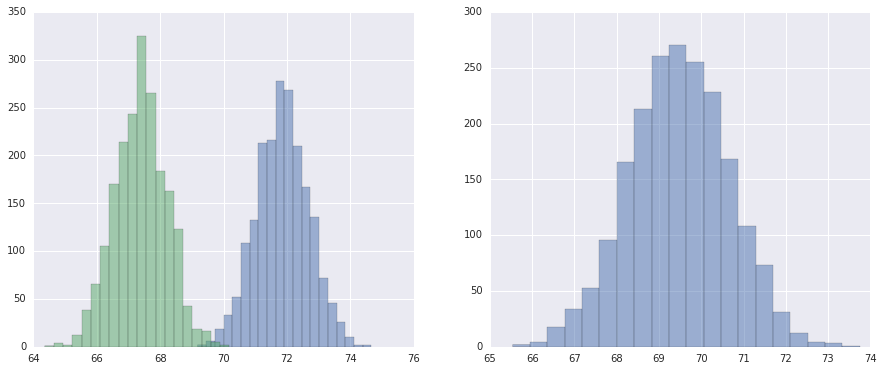

In [178]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
_ = axs[0].hist(unc_traces + mean_possessions_MAP, bins=20, alpha=0.5)
_ = axs[0].hist(nova_traces + mean_possessions_MAP, bins=20, alpha=0.5)
_ = axs[1].hist(nova_traces + unc_traces + mean_possessions_MAP, bins=20, alpha=0.5)

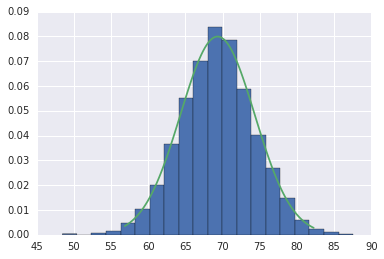

In [254]:
mean = np.mean(traces['predict'])
sigma = np.std(traces['predict'])
# mean = teams['tempo_MAP'].loc[174] + teams['tempo_MAP'].loc[304] - mean_possessions_MAP
# sigma = std_possessions_MAP
x = np.linspace(mean - sigma*2.5, mean_possessions_MAP + sigma*2.5, 100)
plt.hist(traces['predict'],bins=20, normed=True)
plt.plot(x,mlab.normpdf(x,mean,sigma))


plt.show()

In [210]:
N = 10000
unc_samples = np.random.normal(unc_mean, unc_std*10, N)
nova_samples = np.random.normal(nova_mean, nova_std*10, N)
base_samples = np.random.normal(base_mean, base_std, N)
std_samples = np.random.normal(std_mean, std_std, N)
output_samples = np.random.normal(unc_samples + nova_samples + base_samples, std_samples)

69.3773870069 12.5249511237


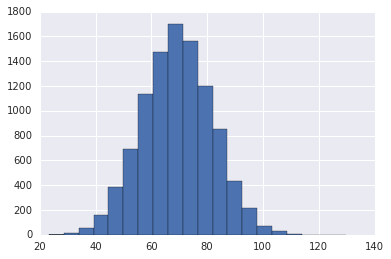

In [211]:
plt.hist(output_samples, bins=20)
print(np.mean(output_samples), np.std(output_samples))

In [212]:
import scipy as sp
import scipy.stats as st

def mean_confidence_interval(data, confidence=0.95):
    a = data
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

In [234]:
pm.df_summary(traces[3000:]).loc['predict__2']

mean        69.601264
sd           4.910453
mc_error     0.076531
hpd_2.5     60.332943
hpd_97.5    79.213514
Name: predict__2, dtype: float64

In [230]:
last_games

,game_id,dt,hteam,hteam_id,ateam,ateam_id,hpts,hposs,apts,aposs,i_hteam,i_ateam,hppp,appp,neutral,home_outcome,poss,season
4699,4087620,2016-03-31,George Washington,249.0,Valparaiso,735.0,76.0,65.350,60.0,65.850,94,301,1.162969,0.911162,True,True,65.600,2016
4971,4089097,2016-04-01,Nevada,466.0,Morehead St.,444.0,85.0,78.375,82.0,78.175,181,169,1.084530,1.048929,False,True,78.275,2016
313,4090446,2016-04-02,Oklahoma,522.0,Villanova,739.0,51.0,63.225,95.0,62.025,210,304,0.806643,1.531640,False,False,62.625,2016
904,4090447,2016-04-02,North Carolina,457.0,Syracuse,688.0,83.0,66.225,66.0,66.175,174,276,1.253303,0.997355,True,True,66.200,2016
903,4093479,2016-04-04,North Carolina,457.0,Villanova,739.0,74.0,64.175,77.0,64.075,174,304,1.153097,1.201717,True,False,64.125,2016


In [215]:
lb, ub = scipy.stats.norm.interval(0.95, loc=np.mean(a), scale=np.std(a))

In [258]:
pm.Gamma?

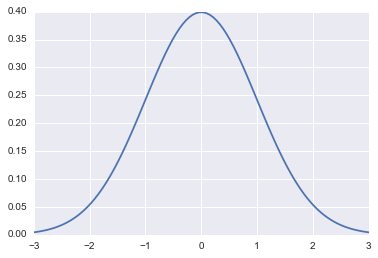

In [263]:
mean = 0
variance = 1
sigma = np.sqrt(variance)
x = np.linspace(-3,3,100)
plt.plot(x,mlab.gam(x,mean,sigma))

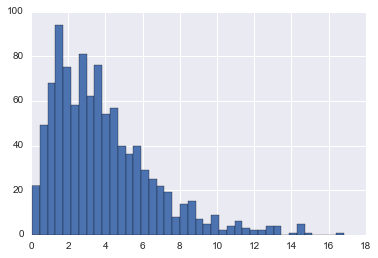

In [272]:
_ = plt.hist(np.random.gamma(2, 2, 1000), bins=40)